In [90]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.transforms import transforms
import torch.nn.functional as F

In [91]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(in_features=kwargs["input_shape"], out_features=128)
        self.encoder_output_layer = nn.Linear(in_features=128, out_features=16)
        self.decoder_hidden_layer = nn.Linear(in_features=16, out_features=128)
        self.decoder_output_layer = nn.Linear(in_features=128, out_features=kwargs["input_shape"])

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        code = torch.nn.functional.normalize(code, p=2.0, dim = 1) # Normalize the latent vector
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AE(input_shape=784).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [93]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root="~/torch_datasets", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="~/torch_datasets", train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [94]:
epochs = 5
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        batch_features = batch_features.view(-1, 784).to(device)
        optimizer.zero_grad()
        outputs = model(batch_features)
        train_loss = criterion(outputs, batch_features)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    loss = loss / len(train_loader)
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/5, loss = 0.052343
epoch : 2/5, loss = 0.035318
epoch : 3/5, loss = 0.031440
epoch : 4/5, loss = 0.029539
epoch : 5/5, loss = 0.028356


In [95]:
test_dataset = torchvision.datasets.MNIST(root="~/torch_datasets", train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False)
test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples = batch_features.view(-1, 784)
        reconstruction = model(test_examples)
        break

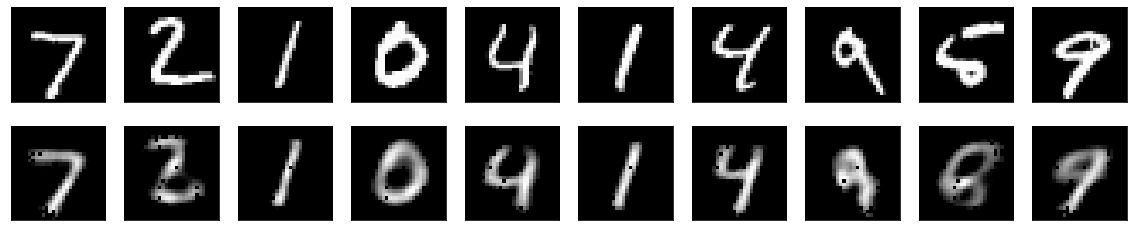

In [96]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()